<h1 align="center">MSIN0114: Business Analytics Consulting Project/Dissertation</h1>

<h3 align="center">Web Scrapping for Monday.com Review on g2.com and trustradius.com</h3>
<br>

 <h3 align="center">Jun 2021</h3>
 <h3 align="center">Github repository:</h3>

<h3>Table of Contents</h3>

* [1. Web Scrapping for Monday.com](#1.-Web-Scrapping-for-Monday.com)
* [2. Load Scrapped Data](#2.-Load-Scrapped-Data)
* [3. Initial Cleaning of Dataset](#3.-Initial-Cleaning-of-Dataset)
* [4. Upload Data into PostgreSQL Database](#4.-Upload-Data-into-PostgreSQL-Database) 
* [5. Save Dataset as csv for Local Access](#5.-Save-Dataset-as-csv-for-Local-Access)


In [1]:
# Basic packages 
import numpy as np                   
import pandas as pd              
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt    
import seaborn as sns

import plotly.express as px

# RDS Database Connection 
import psycopg2

import warnings
warnings.filterwarnings("ignore")


## 1. Web Scrapping for Monday.com

Web Scrapping code for monday.com is stored as spider_1.py and spider_2.py

In [2]:
!python Spider_1.py

1 {'Name': 'Michael J', 'Position': 'Marketing Manager', 'Company': 'Small-Business (50 or fewer emp.)', 'Rating': 'stars-8', 'Date': 'Feb 24, 2021', 'Title': '"It works with accuracy and handles the projects very elegantly."', 'Review': 'What do you like best? There are a couple of things that I love about monday.com. The first is that I can automate tasks to be more comfortable when doing other activities. The second is that I can organize my projects in an easy and orderly way. I also like your support to worry about responding to my requests on time, as well as being very intuitive, easy to use and with a relatively accessible price to the public.  Review collected by and hosted on G2.com. What do you dislike? I do not like that the program contains a sidebar to include information or task parameters, I feel that this makes what you want to show something cumbersome. In addition to this, I have nothing more to say, just that and I hope they improve it.  Review collected by and host

Traceback (most recent call last):
  File "Spider_1.py", line 80, in <module>
    parse_1(t)
  File "Spider_1.py", line 46, in parse_1
    print(count, p_review)
UnicodeEncodeError: 'gbk' codec can't encode character '\xc1' in position 41: illegal multibyte sequence


In [3]:
!python Spider_2.py

## 2. Load Scrapped Data

In [4]:
# import monday data
g2_monday= pd.read_excel ('./html_data/Monday/monday_g2.xls',index_col=0)
tr_monday=pd.read_csv('./html_data/Monday/monday_tr.csv')

## 3. Initial Cleaning of Dataset

Initial Cleaning of dataset is required before the data is stored in a PostgreSQL database. This is to ensure the data matches the desired data type specified in the Schema Customer Review

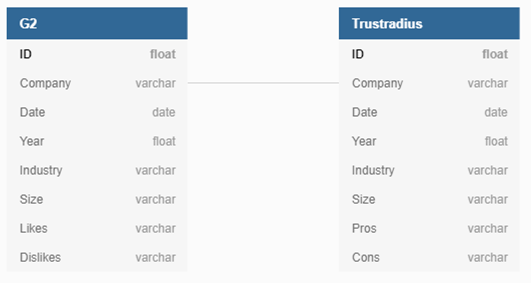

In [6]:
# Drop repeated columns 
g2_monday.drop(columns = ['Company'],inplace = True)

# Rename columns to matches names in Schema
g2_monday.rename(columns ={'Name':'Industry',
                    'Like':'Pros',
                    'Dislike':'Cons',
                    'type':'Size'},inplace = True)

# Create column ID and Company 
g2_monday.reset_index(drop = True, inplace =True)
g2_monday['Company'] = 'Monday'
g2_monday['ID'] = 'G2_'+ g2_monday['Company']+ '_' +g2_monday.index.astype(str)

# Extract year from column Date for column Year 
g2_monday['Date']=pd.to_datetime(g2_monday['Date'])
g2_monday['Year'] = g2_monday['Date'].dt.year.astype(str)

In [7]:
g2_monday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Industry  2498 non-null   object        
 1   Date      2498 non-null   datetime64[ns]
 2   Pros      2490 non-null   object        
 3   Cons      2422 non-null   object        
 4   Size      2498 non-null   object        
 5   Company   2498 non-null   object        
 6   ID        2498 non-null   object        
 7   Year      2498 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 156.2+ KB


A total of 2498 reviews are collected from g2 for monday.com, https://www.g2.com/products/monday-com-monday-com/reviews[].

In [8]:
# Extract the size of the column from the industry column 
# Small-Business: 50 or fewer emp
# Mid-market: 51-1000 emp
# Enterprise: >1000 emp 
tr_monday['size1'] = tr_monday.industry.str.extract('(-\d+)')
tr_monday['size2'] = tr_monday.size1.str.extract('(\d+)')
tr_monday['size2'] = tr_monday['size2'].fillna(0)
tr_monday['size0'] = tr_monday.industry.str.extract('(\d+,\d+)')
tr_monday['size'] = np.where(tr_monday.size2 == 0,tr_monday.size0,tr_monday.size2)
tr_monday.drop(['size1','size2','size0'], axis=1, inplace=True)
tr_monday['size'] = np.where(tr_monday['size'] == '10,001',10001,tr_monday['size'])
tr_monday['size']=tr_monday['size'].astype('int')

# Categorise the size according the definition provided by G2.com 
tr_monday['Size'] = tr_monday['size'].apply(lambda x: 
                              'Med-Market' if x in range(51,1000) else 
                              'Small-Business' if x in range(0,51) else 
                              'Enterprise' )

tr_monday.drop(['size'],axis = 1, inplace = True)

# Remove the nunber of employees information from the industry column 
tr_monday[['Industry', 'Number of employees']] = tr_monday['industry'].str.split(',', 1, expand=True)


# Drop repeated columns 
tr_monday.drop(columns = ['Company','Name','position','Rating','Title','industry','Number of employees'],inplace = True)

# Create column ID and Company 
tr_monday.reset_index(drop = True, inplace =True)
tr_monday['Company'] = 'Monday'
tr_monday['ID'] = 'TR_'+ tr_monday['Company']+ '_' +tr_monday.index.astype(str)

# Extract year from column Date for column Year 
tr_monday['Date']=pd.to_datetime(tr_monday['Date'])
tr_monday['Year'] = tr_monday['Date'].dt.year.astype(str)


In [9]:
tr_monday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1002 non-null   datetime64[ns]
 1   Pros      1002 non-null   object        
 2   Cons      981 non-null    object        
 3   Size      1002 non-null   object        
 4   Industry  1002 non-null   object        
 5   Company   1002 non-null   object        
 6   ID        1002 non-null   object        
 7   Year      1002 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 62.8+ KB


A total of 1002 reviews are collected from Trustradius.com for monday.com, https://www.trustradius.com/products/monday/reviews

## 4. Upload Data into PostgreSQL Database

In [16]:
# Enter credential for database 
engine = psycopg2.connect(
    host="database-1.cg80f0qtitmf.eu-west-1.rds.amazonaws.com",
    user="postgres",
    password="chenziyi",
    port=5432
)

In [11]:
cur = engine.cursor()
cur.execute(""" 
     DROP SCHEMA IF EXISTS schema_Customer_Review CASCADE;
     
     CREATE SCHEMA IF NOT EXISTS schema_Customer_Review;
     
     CREATE TABLE IF NOT EXISTS schema_Customer_Review.G2 (
      ID varchar PRIMARY KEY,
      Company varchar,
      Date date,
      Year varchar,
      Industry varchar,
      Size varchar,
      Pros varchar,
      Cons varchar);
      
     CREATE TABLE IF NOT EXISTS schema_Customer_Review.Trustradius (
      ID varchar PRIMARY KEY,
      Company varchar,
      Date date,
      Year varchar,
      Industry varchar,
      Size varchar,
      Pros varchar,
      Cons varchar);
      
      """)

print("Table created successfully")

engine.commit()
engine.close()

Table created successfully


In [13]:
# Insert scrapped data into the database 
# Monday.com for Table g2


cur = engine.cursor()
s ="""INSERT INTO schema_Customer_review.g2(Industry, Date, Pros, Cons, Size, Company, ID, Year) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""



for index in range(len(g2_monday)):
    obj = []
    l=[]
    for col in g2_monday.columns:
        l.append(g2_monday[col][index])
    obj.append(l)
    cur.executemany(s, obj)
    engine.commit()
    
print("Insert successfully")

engine.close()

Insert successfully


In [15]:
# Insert scrapped data into the database 
# Monday.com for Table Trustradius


cur = engine.cursor()
s ="""INSERT INTO schema_Customer_review.Trustradius(Date, Pros, Cons, Size, Industry, Company, ID, Year) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""

print("Insert successfully")

for index in range(len(tr_monday)):
    obj = []
    l=[]
    for col in tr_monday.columns:
        l.append(tr_monday[col][index])
    obj.append(l)


    cur.executemany(s, obj)
    engine.commit()
engine.close()

Insert successfully


In [17]:
TR= pd.read_sql("select * from schema_Customer_review.Trustradius", engine)
engine.close()

In [18]:
TR

,id,company,date,year,industry,size,pros,cons
0,TR_Monday_0,Monday,2021-06-08,2021,Apparel & Fashion,Small-Business,We can push updates and information for design...,The way emails display after being pushed as a...
1,TR_Monday_1,Monday,2021-06-07,2021,Computer Software,Med-Market,VersitileFlexibleEasy-to-use,"Software Integrations, I feel like if we could..."
2,TR_Monday_2,Monday,2021-06-05,2021,Education Management,Med-Market,"Project management of all our past, ongoing, a...","If I recall, there were some sub item areas th..."
3,TR_Monday_3,Monday,2021-05-20,2021,Retail,Small-Business,Notifications - My boards are set up to update...,Biggest Con - Adding seats to monday.comLet me...
4,TR_Monday_4,Monday,2021-05-19,2021,Higher Education,Small-Business,Collaboration. I have never used a platform wh...,Automations. There are a few things I'd like t...
...,...,...,...,...,...,...,...,...
997,TR_Monday_997,Monday,2019-01-07,2019,Online Media Company,Small-Business,Project management - it's the best tool I've f...,Document integration.It's a lot to manage for ...
998,TR_Monday_998,Monday,2018-08-29,2018,Financial Services Company,Small-Business,Easily assign tasks and collaborate.Easy to se...,"Honestly, I think it's great as is. We haven't..."
999,TR_Monday_999,Monday,2018-12-04,2018,Non-Profit Organization Management Company,Small-Business,It's color coded so I can clearly see the next...,I haven't found any yet.
1000,TR_Monday_1000,Monday,2018-08-08,2018,Retail Company,Small-Business,Monday does an extremely good job of keeping e...,Monday definitely does have a learning curve. ...


## 5. Save Dataset as csv for Local Access

In [19]:
# Save as csv for local access 
df_monday  = pd.concat([tr_monday,g2_monday])
df_monday.info()
df_monday.to_csv('Monday review.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 2497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3500 non-null   datetime64[ns]
 1   Pros      3492 non-null   object        
 2   Cons      3403 non-null   object        
 3   Size      3500 non-null   object        
 4   Industry  3500 non-null   object        
 5   Company   3500 non-null   object        
 6   ID        3500 non-null   object        
 7   Year      3500 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 246.1+ KB


In [20]:
df_monday.head()

,Date,Pros,Cons,Size,Industry,Company,ID,Year
0,2021-06-08,We can push updates and information for design...,The way emails display after being pushed as a...,Small-Business,Apparel & Fashion,Monday,TR_Monday_0,2021
1,2021-06-07,VersitileFlexibleEasy-to-use,"Software Integrations, I feel like if we could...",Med-Market,Computer Software,Monday,TR_Monday_1,2021
2,2021-06-05,"Project management of all our past, ongoing, a...","If I recall, there were some sub item areas th...",Med-Market,Education Management,Monday,TR_Monday_2,2021
3,2021-05-20,Notifications - My boards are set up to update...,Biggest Con - Adding seats to monday.comLet me...,Small-Business,Retail,Monday,TR_Monday_3,2021
4,2021-05-19,Collaboration. I have never used a platform wh...,Automations. There are a few things I'd like t...,Small-Business,Higher Education,Monday,TR_Monday_4,2021


In total, 3500 reviews are collect for Monday.com from both g2.com and trustraidus.com